# 使用Opencv實作車牌辨識

- 車牌定位：透過輪廓檢測定位汽車上的車牌
- 車牌切割：將車牌切割出來
- 車牌辨識：透過easyOCR辨識車牌

# 0. Install and import dependencies

In [1]:
#!pip install easyocr
#!pip install imutils

In [137]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import easyocr

# 1. Read image, grayscale, blur

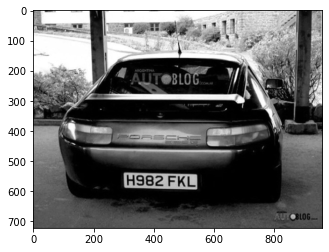

In [138]:
img = cv2.imread('./image4.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

# 2. Apply filter and find edges for localization

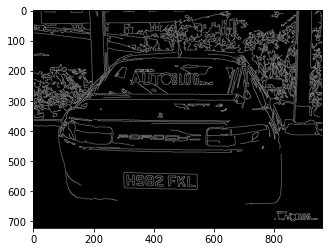

In [139]:
#blur = cv2.GaussianBlur(gray, (19,19), 1) # noise rediction
blur = cv2.bilateralFilter(gray, 11, 17, 17)
canny = cv2.Canny(blur, 30, 200) # edge detection
#canny = cv2.Canny(blur, 100, 175) # edge detection
plt.imshow(canny, cmap='gray')

# 3. Find contours and apply mask

In [140]:
#keypoints = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours = imutils.grab_contours(keypoints) # 回傳contours
contours,_ = cv2.findContours(canny.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # 排序contours, 並回傳top 10 contours區域。 
                                                                    # reverse=True代表由小到大排列


In [142]:
location = None

for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

1


In [135]:
location

array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

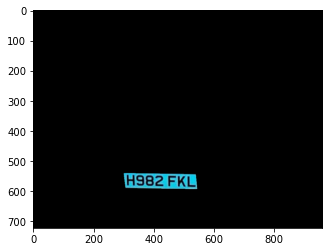

In [136]:
blank = np.zeros(gray.shape, np.uint8)
mask = cv2.drawContours(blank, [location], 0, 255, -1)
masked = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked, cmap='gray')

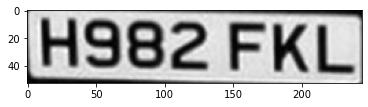

In [128]:
(x, y) = np.where(mask==255) # finding section where image isn't black
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped = gray[x1:x2+1, y1:y2+1]
plt.imshow(cropped, cmap='gray')

# 4. Use EasyOCR to read text

In [26]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped)
result

AttributeError: module 'torch.backends' has no attribute 'mps'

# 5. Render result

In [115]:
approx[2][0]

array([543, 592], dtype=int32)

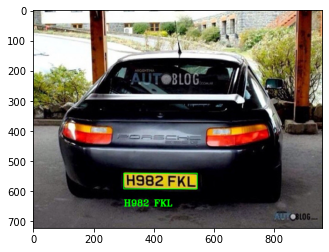

In [117]:
#text = result[0][1] 
text = 'H982 FKL'
font = cv2.FONT_HERSHEY_TRIPLEX
res = cv2.putText(img, text, (approx[0][0][0], approx[1][0][1]+60), font , 1.0, (0,255,0), 2)
res = cv2.rectangle(img, (approx[0][0]), (approx[2][0]), (0,255,0), 2)
plt.imshow(res[:,:,::-1])

# 備註 多邊形逼近 (approxPolyDP)

cv2.approxPolyDP(curve,epsilon,closed,approxCurve = true)

- curve：點集合(Input vector of a 2D point)
- epsilon：原曲線與近似曲線之間的最大距離。此值越小，近似結果的曲線越接近原曲線
- closed：近似曲線是否閉合
    - True：近似曲線閉合（第一个頂點與最後一個頂點相互連接）
    - False：近似曲線不閉合
- approxCurve：近似曲線的結果與原輸入曲線的type是否相同(The type should match the type of the input curve.)

# Practice1

In [14]:
import cv2
import matplotlib.pyplot as plt

def pltimg(img):
    plt.imshow(img[:,:,::-1])
    plt.show()

def pltimg_gray(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [15]:
img = cv2.imread('./shape1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY)

In [16]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'總共找到多少個contours : {len(contours)}')
print(f'星型共有{len(contours[0])}個點')
print(f'四邊形共有{len(contours[1])}個點')

總共找到多少個contours : 2
星型共有147個點
四邊形共有4個點


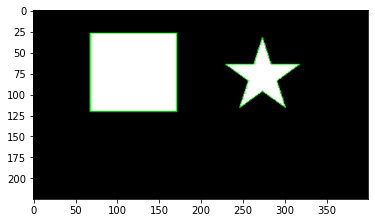

In [17]:
res = img.copy()
res = cv2.drawContours(res, contours, -1, (0,255,0), 1)
pltimg(res)

In [155]:
"""
上述實驗可以看到星形有147個點，可以使用多邊形逼近法降低頂點數
而對contour做approxPolyDP的目的，可以想成是用粗一點的線來描邊，來忽略掉細微的毛邊或雜點
"""

# 星型
approx1 = cv2.approxPolyDP(contours[0], 10, True)
print(f'對星型做多邊形近似後，共有{len(approx1)}個點')

# 四邊形
approx2 = cv2.approxPolyDP(contours[1], 10, True)
print(f'對星型做多邊形近似後，共有{len(approx2)}個點')

對星型做多邊形近似後，共有10個點
對星型做多邊形近似後，共有4個點


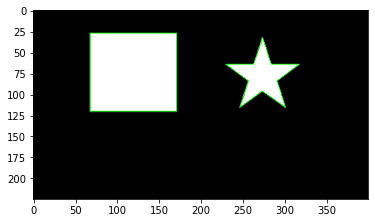

In [159]:
res2 = img.copy()

res2 = cv2.drawContours(res2, [approx1], 0, (0,255,0), 1)
res2 = cv2.drawContours(res2, [approx2], 0, (0,255,0), 1)
pltimg(res2)

# Practice2

- 測試不同epsilon的結果

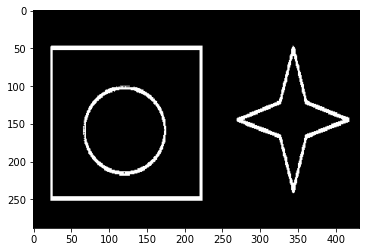

In [68]:
img = cv2.imread('./shape2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#blur = cv2.GaussianBlur(gray, (19,19), 1)
#canny = cv2.Canny(blur, 30, 200)
_, thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY_INV)

pltimg_gray(thresh)

In [69]:
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'總共找到多少個contours : {len(contours)}')


總共找到多少個contours : 2


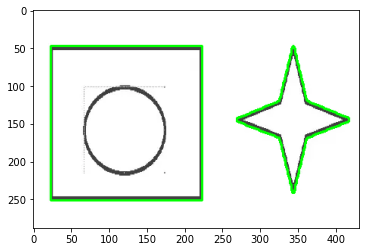

In [70]:
res = img.copy()
res = cv2.drawContours(res, contours, -1, (0,255,0), 2)
pltimg(res)

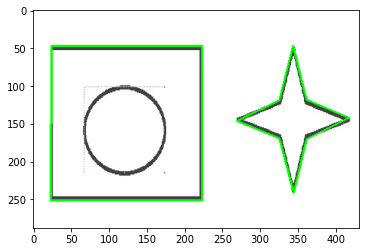

In [71]:
# epsilon = 10
approx1 = cv2.approxPolyDP(contours[0], 10, True)
approx2 = cv2.approxPolyDP(contours[1], 10, True)

res2 = img.copy()
res2 = cv2.drawContours(res2, [approx1], -1, (0,255,0), 2)
res2 = cv2.drawContours(res2, [approx2], -1, (0,255,0), 2)
pltimg(res2)

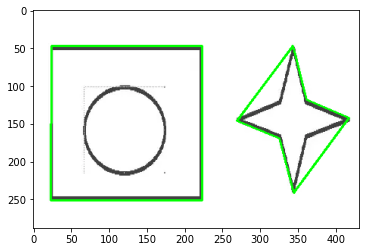

In [76]:
# epsilon = 29
approx1 = cv2.approxPolyDP(contours[0], 29, True)
approx2 = cv2.approxPolyDP(contours[1], 29, True)

res2 = img.copy()
res2 = cv2.drawContours(res2, [approx1], -1, (0,255,0), 2)
res2 = cv2.drawContours(res2, [approx2], -1, (0,255,0), 2)
pltimg(res2)

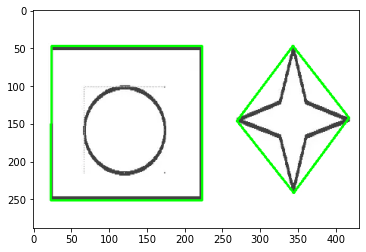

In [78]:
# epsilon = 30
approx1 = cv2.approxPolyDP(contours[0], 30, True)
approx2 = cv2.approxPolyDP(contours[1], 30, True)

res2 = img.copy()
res2 = cv2.drawContours(res2, [approx1], -1, (0,255,0), 2)
res2 = cv2.drawContours(res2, [approx2], -1, (0,255,0), 2)
pltimg(res2)